In [56]:
import sqlite3

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# Can this run on GPU
tf.config.list_physical_devices('GPU')

[]

In [3]:
# Constants
RANDOM_STATE = 32  # DO NOT CHANGE, images will have to be resorted
PROCESSED_IMAGES_DIR = "data/images_processed/"
PROCESSED_IMAGE_ARRAY_NPY = "data/image_processed_array.npy"

TRAIN_IMAGES_DIR = "data/train_images/"
TEST_IMAGES_DIR = "data/test_images/"

## Import the data and split for testing and training

In [4]:
# load from SQLite database
connection = sqlite3.connect("data/galaxy_data.sqlite")
df_import = pd.read_sql("SELECT * from galaxy_data", connection)
connection.close()

In [5]:
# Make sure there are no null values in data
df_import.isnull().any(axis=1).sum()

0

In [6]:
# keep only needed values
stratify_data = df_import["class_reduced"].values
x_image_id_names = df_import["asset_id"]

y_output_data = df_import.drop(["objid", "sample", "asset_id", "dr7objid", "ra", "dec", "gz2_class", "class_reduced"], axis=1)
y_output_data.shape

(239267, 37)

`RANDOM_STATE` needs to be the same as the value in `data_image_cleaning.ipynb`

In [7]:
# Split data into testing and training
# X is asset names, not the actual images
X_train_assets, X_test_assets, y_train, y_test = train_test_split(x_image_id_names,
                                                                  y_output_data,
                                                                  random_state=RANDOM_STATE,
                                                                  stratify=stratify_data)
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [8]:
def load_png_images_from_directory(directory: str,  image_list: list[int]) -> np.array:
    """
    Load grayscale PNG images from a directory into a numpy array.

    Images must be integer names in `image_list`, order is important
    
    :param directory: path to directory
    :param image_list: array of integers representing file names
    :return: array of image arrays
    """
    images = []
    for img_name in image_list:
        img_array = cv2.imread(f"{directory}{img_name}.png", cv2.IMREAD_GRAYSCALE).astype("float32") / 255.0
        images.append(img_array)
    X_image_array = np.array(images)
    return X_image_array

In [9]:
# TODO THIS IS TEST_IMAGES FOR SPEED
# X_train_images = load_png_images_from_directory(TRAIN_IMAGES_DIR, X_train_assets)  # Actual values
X_train_images = load_png_images_from_directory(TEST_IMAGES_DIR, X_test_assets)  # TODO test values taking its place
print("X_train_images Shape:", X_train_images.shape)
print("X_train_images Size", X_train_images.nbytes, "bytes")
print("y_train Shape:", y_train.shape)

X_train_images Shape: (59817, 106, 106)
X_train_images Size 2688415248 bytes
y_train Shape: (179450, 37)


In [10]:
print("y_test Shape:", y_test.shape)  # TODO move to end next to X_test

y_test Shape: (59817, 37)


In [ ]:
# # create weights with sklearn
# # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)  # unique does not make sense for a regression problem

# class_weights = np.sum(y_train, axis=0) / np.sum(y_train)

## Create the Model
This model is a regression model even though is appears to be classifying galaxies. That is because it is really measuring the confidence levels of the group of people classifying the galaxies.

In [68]:
# Add callbacks for Early Stopping and Checkpoints
# - https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoints = ModelCheckpoint("data/model/checkpoints/cp-{epoch:04d}.ckpt", monitor="loss", mode="min", verbose=0, save_weights_only=True)
early_stopping = EarlyStopping(monitor="loss", patience=5)
callbacks_ = [checkpoints, early_stopping]

In [69]:
# Visualize Loss and MAE over the epochs
history_plt_style = {'axes.edgecolor':'white',
             'axes.facecolor': '#333',
             'axes.labelcolor': 'white',
             'axes.titlecolor': 'white',
             'axes.grid': True,
             'grid.color': '#222',
             'legend.labelcolor': 'white',
             'legend.loc': 'upper right',
             'xtick.color':'white',
             'ytick.color':'white'}

def plot_history(fit_history: History):
    """Creates a plot for history of MAE and Loss (MSE)"""
    with plt.rc_context(history_plt_style):
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        fig.patch.set_facecolor('#222')
        axs[0].plot(fit_history.history['mae'], label='train_mae')
        axs[0].plot(fit_history.history['val_mae'], label='val_mae')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Mean Absolute Error')
        axs[0].legend()
        axs[1].plot(fit_history.history['loss'], label='train_loss')
        axs[1].plot(fit_history.history['val_loss'], label='val_loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss (Mean Squared Error)')
        axs[1].legend()
        plt.show()

In [76]:
IMG_SIZE = X_train_images[0].shape[0]
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

# Create a sequential model
model = Sequential()

# Add convolution layers
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=INPUT_SHAPE))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2, seed=RANDOM_STATE))
# Flatten the output from convolution layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, seed=RANDOM_STATE))

model.add(Dense(64, activation='relu'))

# Add the output layer with 37 units (for 37 classes)
# TODO is `softmax` good for regression, probably relu?
# model.add(Dense(37, activation='softmax'))
model.add(Dense(37, activation='relu'))

# Compile the model
# TODO Since values are like confidence levels from the classifiers, this is really a regression, not a classification
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=["mae"])  # mse=mean_squared_error

# Print the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 104, 104, 16)      160       
                                                                 
 conv2d_31 (Conv2D)          (None, 103, 103, 32)      2080      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 51, 51, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 24, 24, 128)     

In [ ]:
# Create weight function/array/list to give weight to rare categories
class_weights = {
    0: 1,   # t01_smooth
    1: 1,   # t01_features
    2: 1,   # t01_star_artifact
    3: 1,   # t02_edge_on_yes
    4: 1,   # t02_edge_on_no
    5: 1,   # t03_bar_yes
    6: 1,   # t03_bar_no
    7: 1,   # t04_spiral_yes
    8: 1,   # t04_spiral_no
    9: 1,   # t05_bulge_prominence_no_bulge
    10: 1,  # t05_bulge_prominence_just
    11: 1,  # t05_bulge_prominence_obvious
    12: 1,  # t05_bulge_prominence_dominant
    13: 1,  # t06_odd_yes
    14: 1,  # t06_odd_no
    15: 1,  # t07_rounded_completely_round
    16: 1,  # t07_rounded_in_between
    17: 1,  # t07_rounded_cigar_shaped
    18: 1,  # t08_odd_feature_ring
    19: 1,  # t08_odd_feature_lens_or_arc
    20: 1,  # t08_odd_feature_disturbed
    21: 1,  # t08_odd_feature_irregular
    22: 1,  # t08_odd_feature_other
    23: 1,  # t08_odd_feature_merger
    24: 1,  # t08_odd_feature_dust_lane
    25: 1,  # t09_bulge_shape_rounded
    26: 1,  # t09_bulge_shape_boxy
    27: 1,  # t09_bulge_shape_no_bulge
    28: 1,  # t10_arms_winding_tight
    29: 1,  # t10_arms_winding_medium
    30: 1,  # t10_arms_winding_loose
    31: 1,  # t11_arms_number_1
    32: 1,  # t11_arms_number_2
    33: 1,  # t11_arms_number_3
    34: 1,  # t11_arms_number_4
    35: 1,  # t11_arms_number_more_than_4
    36: 1,  # t11_arms_number_cant_tell
}

### Train the Model

Epoch 1/10
27/27 [==============================] - 361s 12s/step - loss: 0.1148 - mae: 0.2287 - val_loss: 0.0888 - val_mae: 0.2074
Epoch 2/10
27/27 [==============================] - 203s 7s/step - loss: 0.0888 - mae: 0.2065 - val_loss: 0.0845 - val_mae: 0.2018
Epoch 3/10
27/27 [==============================] - 226s 8s/step - loss: 0.0845 - mae: 0.2019 - val_loss: 0.0804 - val_mae: 0.1970
Epoch 4/10
27/27 [==============================] - 200s 7s/step - loss: 0.0812 - mae: 0.1974 - val_loss: 0.0775 - val_mae: 0.1910
Epoch 5/10
27/27 [==============================] - 228s 8s/step - loss: 0.0789 - mae: 0.1925 - val_loss: 0.0757 - val_mae: 0.1879
Epoch 6/10
27/27 [==============================] - 174s 6s/step - loss: 0.0772 - mae: 0.1890 - val_loss: 0.0747 - val_mae: 0.1842
Epoch 7/10
27/27 [==============================] - 230s 9s/step - loss: 0.0755 - mae: 0.1856 - val_loss: 0.0730 - val_mae: 0.1795
Epoch 8/10
27/27 [==============================] - 226s 8s/step - loss: 0.0740 - 

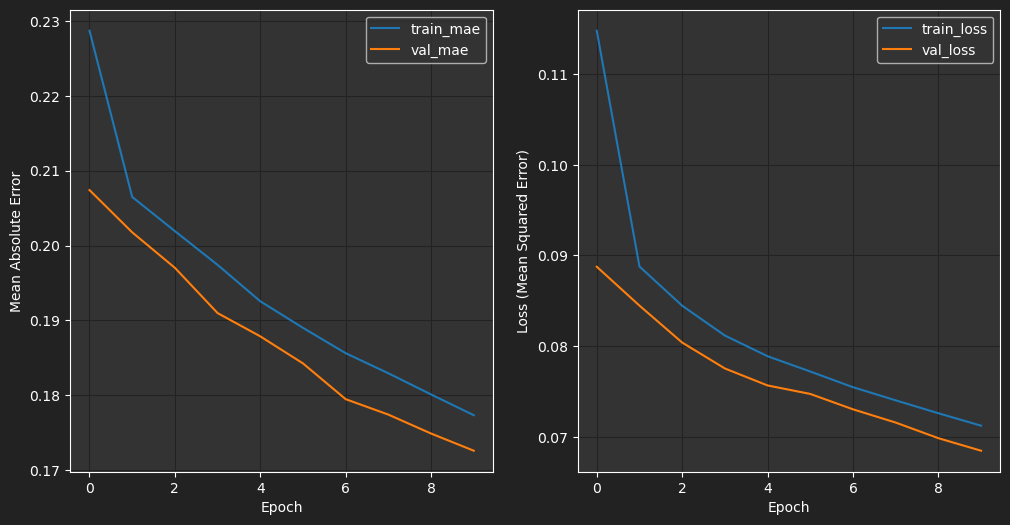

In [77]:
history = model.fit(X_train_images,  # TODO make sure this is correct TESTING ONLY, this is not actually the training data
                    y_test,  # TODO testing only replace with y_train
                    # class_weight=class_weights,
                    epochs=10,
                    callbacks=callbacks_,
                    batch_size=2_000,
                    validation_split=0.1)

# Plots
plot_history(history)

In [ ]:
model.save("data/model/GalaxyConfidenceModel.keras")

---

## Test the model

In [ ]:
X_test_images = load_png_images_from_directory(TEST_IMAGES_DIR, X_test_assets)
print("X_test_images Shape:", X_test_images.shape)
print("X_test_images Size", X_test_images.nbytes, "bytes")
print("y_test Shape:", y_test.shape)

In [ ]:
# Evaluate the model using the test data
# model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
model_loss, model_metrics = model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Metrics: {model_metrics}")

---

## Make Predictions

In [79]:
# This is a face on Barred Spiral Galaxy with 2 arms. It has been scaled down and has very distinct features
predict_img = cv2.imread(r"C:\Users\Zachary\Documents\UTB\Classwork\Project4\examples\test_spiral_bar_2_arm_EDIT.png", cv2.IMREAD_GRAYSCALE).astype("float32") / 255.0
predict_img = np.expand_dims(predict_img, axis=0)  # I do not know why these are necessary but they are
predict_img = np.expand_dims(predict_img, axis=3)  # ^
print(predict_img.shape)
predictions = model.predict(predict_img)
S_predict = pd.Series(predictions[0], y_output_data.columns.values)
S_predict

(1, 106, 106, 1)
1/1 [==============================] - 0s 29ms/step


t01_smooth_or_features_a01_smooth_debiased              0.148547
t01_smooth_or_features_a02_features_or_disk_debiased    0.786167
t01_smooth_or_features_a03_star_or_artifact_debiased    0.000000
t02_edgeon_a04_yes_debiased                             0.000000
t02_edgeon_a05_no_debiased                              0.957853
t03_bar_a06_bar_debiased                                0.359831
t03_bar_a07_no_bar_debiased                             0.590393
t04_spiral_a08_spiral_debiased                          0.807135
t04_spiral_a09_no_spiral_debiased                       0.164943
t05_bulge_prominence_a10_no_bulge_debiased              0.099529
t05_bulge_prominence_a11_just_noticeable_debiased       0.539523
t05_bulge_prominence_a12_obvious_debiased               0.337686
t05_bulge_prominence_a13_dominant_debiased              0.016669
t06_odd_a14_yes_debiased                                0.337233
t06_odd_a15_no_debiased                                 0.618331
t07_rounded_a16_completel